In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import create_dataloaders, plot_tsne
import VariationalAutoDecoder as VAD
import AutoDecoder as AD
import importlib
import evaluate
import matplotlib.pyplot as plt

In [2]:
importlib.reload(VAD)
importlib.reload(AD)

<module 'AutoDecoder' from '/home/nativ/Deep_learning_technion/Project - Autodecoder/AutoDecoder.py'>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)

In [4]:
# Create data loaders
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path="dataset", batch_size=32)

In [5]:
# Initialize model
latent_dim = 128
output_shape = (1, 28, 28)
vad = VAD.VariationalAutoDecoder(latent_dim, output_shape).to(device)

In [6]:
# Initialize distribution parameters
num_samples = len(train_ds)
distribution = 'exponential'  # or 'gaussian' or 'uniform'

if distribution == 'gaussian':
    mu = torch.randn(num_samples, latent_dim, requires_grad=True, device=device)
    log_var = torch.randn(num_samples, latent_dim, requires_grad=True, device=device)
    dist_params = [mu, log_var]
elif distribution == 'exponential':
    log_rate = torch.randn(num_samples, latent_dim, requires_grad=True, device=device)
    dist_params = [log_rate]
elif distribution == 'uniform':
    low = torch.randn(num_samples, latent_dim, requires_grad=True, device=device)
    log_length= torch.randn(num_samples, latent_dim, requires_grad=True, device=device)
    dist_params = [low, log_length]

# Initialize optimizer
optimizer = optim.Adam(list(vad.parameters()) + dist_params, lr=1e-2)

In [7]:
# Train the model
train_losses = VAD.train_variational_auto_decoder(vad, train_dl, optimizer, dist_params, device, distribution, epochs=100
, beta=1)

Epoch [1/100], Train Loss: 83.6843
Epoch [2/100], Train Loss: 76.1415
Epoch [3/100], Train Loss: 69.5114
Epoch [4/100], Train Loss: 63.4879
Epoch [5/100], Train Loss: 58.0326
Epoch [6/100], Train Loss: 53.0975
Epoch [7/100], Train Loss: 48.6316
Epoch [8/100], Train Loss: 44.5834
Epoch [9/100], Train Loss: 40.9122
Epoch [10/100], Train Loss: 37.5802
Epoch [11/100], Train Loss: 34.5491
Epoch [12/100], Train Loss: 31.7880
Epoch [13/100], Train Loss: 29.2753
Epoch [14/100], Train Loss: 26.9777
Epoch [15/100], Train Loss: 24.8815
Epoch [16/100], Train Loss: 22.9617
Epoch [17/100], Train Loss: 21.2080
Epoch [18/100], Train Loss: 19.6038
Epoch [19/100], Train Loss: 18.1295
Epoch [20/100], Train Loss: 16.7803
Epoch [21/100], Train Loss: 15.5384
Epoch [22/100], Train Loss: 14.4003
Epoch [23/100], Train Loss: 13.3565
Epoch [24/100], Train Loss: 12.3923
Epoch [25/100], Train Loss: 11.5088
Epoch [26/100], Train Loss: 10.6962
Epoch [27/100], Train Loss: 9.9477
Epoch [28/100], Train Loss: 9.2587
Epo

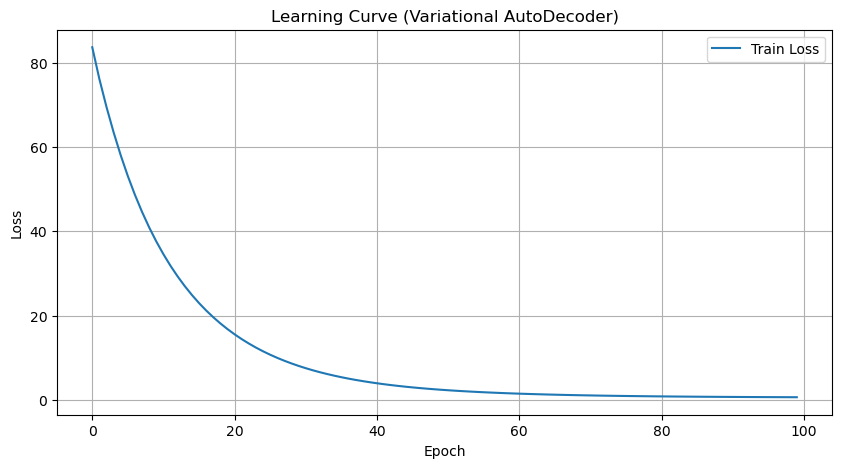

In [8]:
# Plot learning curve
VAD.plot_learning_curve(train_losses)

In [9]:
save_path = f"{distribution}/part2_model.pth"
torch.save(vad.state_dict(), save_path)

In [10]:
# # Load the saved VAD model
# load_path = f"{distribution}/part2_model.pth"
# vad.load_state_dict(torch.load(load_path))
# #vad.eval()  # Set the model to evaluation mode

# print(f"Loaded VAD model from {load_path}")


In [11]:
train_loss = VAD.evaluate_vad_model(vad, train_dl, optimizer, dist_params, epochs=100, device=device, distribution=distribution)
print(f"Train Loss after additional 100 epochs of optimizng reconstruction loss: {train_loss:.4f}")

Train Loss after additional 100 epochs of optimizng reconstruction loss: 0.3032


Train Loss right after training: 0.2978


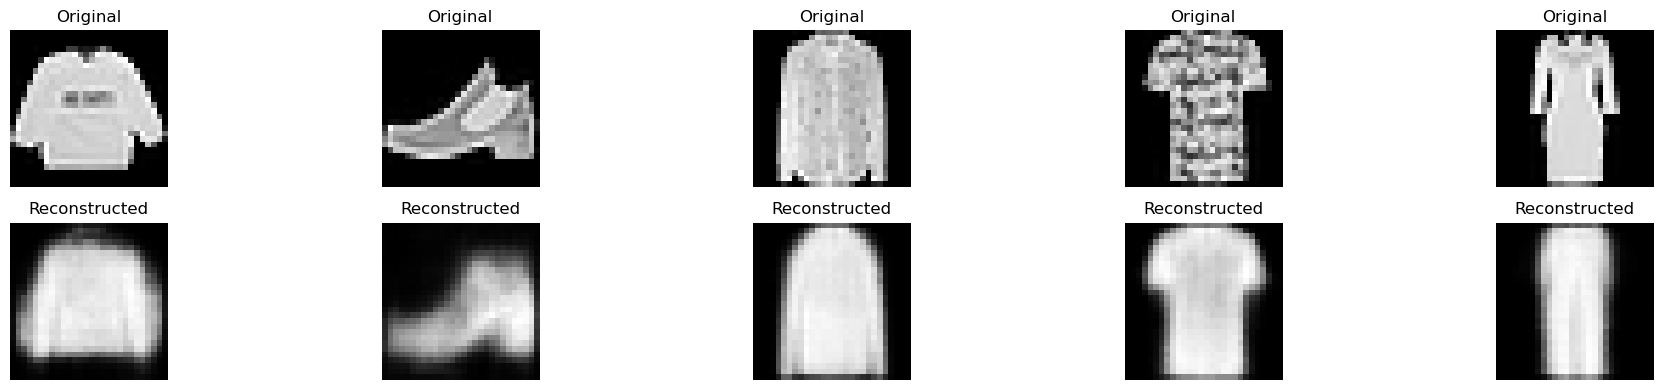

In [12]:
train_latents_optimizer= optim.Adam(dist_params, lr=1e-2)
train_loss = VAD.evaluate_vad_model(vad, train_dl, train_latents_optimizer, dist_params, epochs=1, device=device, distribution=distribution)
print(f"Train Loss right after training: {train_loss:.4f}")
VAD.visualize_vad_reconstructions(vad, train_dl, dist_params, device, distribution=distribution, num_samples=5)

In [13]:
train_latents = VAD.reparameterize(distribution, *dist_params)
plot_tsne(train_ds, train_latents, f"{distribution}/part2_train_right_after_training_tsne.png", plot_title="t-SNE Plot")

<Figure size 800x600 with 0 Axes>

Train Loss after 100 epochs: 0.2619


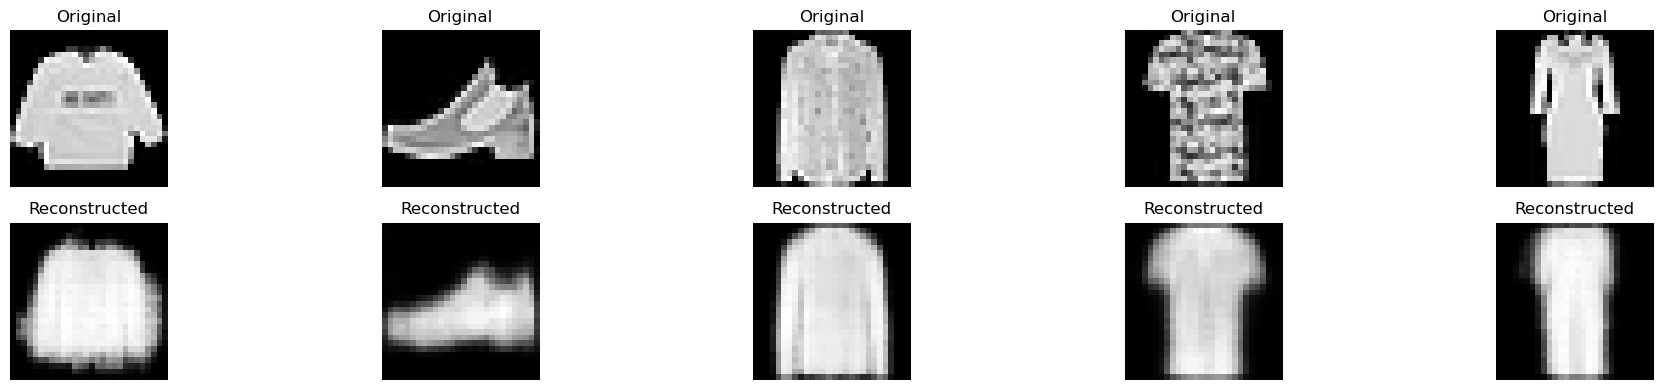

In [14]:
train_loss = VAD.evaluate_vad_model(vad, train_dl, train_latents_optimizer, dist_params, epochs=100, device=device, distribution=distribution)
print(f"Train Loss after 100 epochs: {train_loss:.4f}")
VAD.visualize_vad_reconstructions(vad, train_dl, dist_params, device, distribution=distribution, num_samples=5)

In [15]:
train_latents = VAD.reparameterize(distribution, *dist_params)
plot_tsne(train_ds, train_latents, f"{distribution}/part2_train_after_100_epochs_tsne.png", plot_title="t-SNE Plot")


<Figure size 800x600 with 0 Axes>

In [16]:
num_samples = len(test_ds)
test_dist_params = [torch.randn(num_samples, latent_dim, requires_grad=True, device=device), torch.randn(num_samples, latent_dim, requires_grad=True, device=device)]
test_optimizer = optim.Adam(test_dist_params, lr=1e-2)

Test Loss: 0.2950


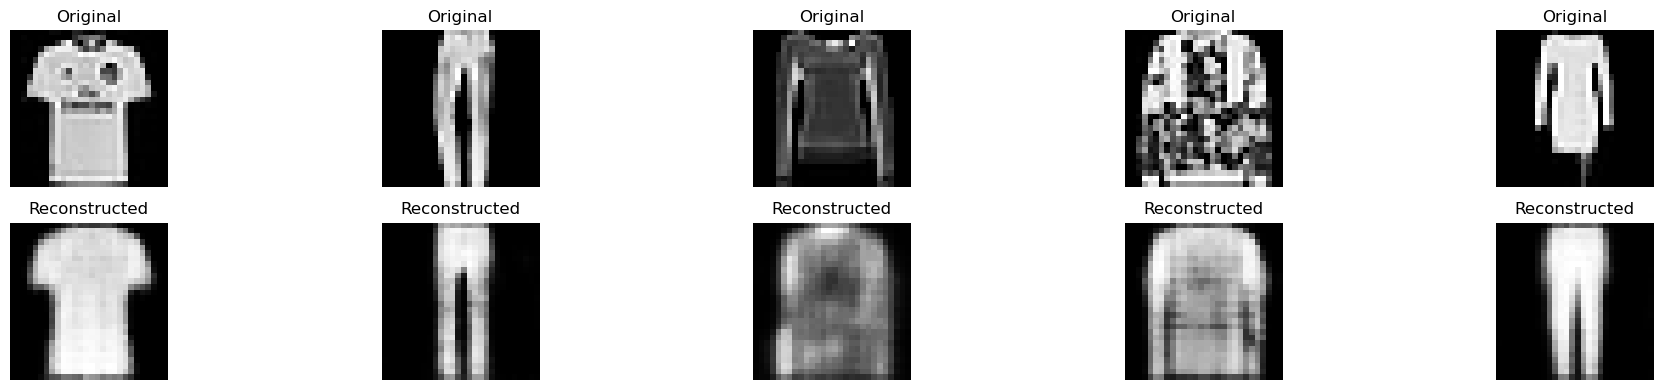

In [17]:
test_loss = VAD.evaluate_vad_model(vad, test_dl, test_optimizer, test_dist_params, epochs=100, device=device, distribution=distribution)
print(f"Test Loss: {test_loss:.4f}")
VAD.visualize_vad_reconstructions(vad, test_dl, test_dist_params, device, distribution=distribution, num_samples=5)

In [18]:
test_latents = VAD.reparameterize(distribution, *test_dist_params)
plot_tsne(test_ds, test_latents, f"{distribution}/part2_test_tsne.png", plot_title="t-SNE Plot")

<Figure size 800x600 with 0 Axes>

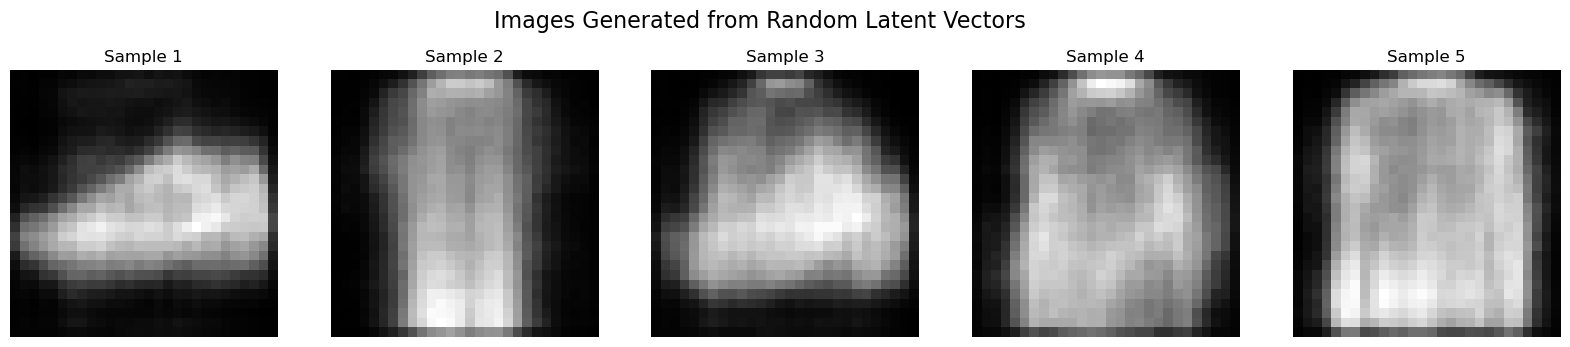

In [39]:
# Sample 5 random latent vectors from standard normal distribution
num_samples = 5
if distribution == 'gaussian':
    random_latents = torch.randn(num_samples, latent_dim, device=device)
elif distribution == 'exponential':
    exponential_dist = torch.distributions.Exponential(1)
    random_latents = exponential_dist.sample((num_samples, latent_dim)).to(device)
elif distribution == 'uniform':
    random_latents = torch.rand(num_samples, latent_dim, device=device)

# Generate images from the random latent vectors
vad.eval()
with torch.no_grad():
    generated_images = vad(random_latents)

# Visualize the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle('Images Generated from Random Latent Vectors', fontsize=16)
plt.show()


In [40]:
sample_trouser = test_ds[1][1]
sample_shirt = test_ds[7][1]

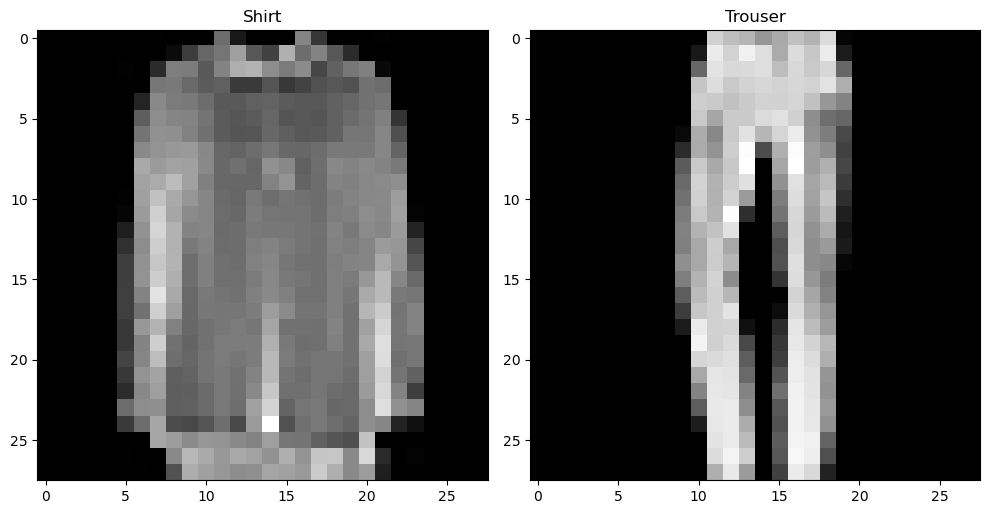

In [41]:
# plot the samples with titles shirt and trouser   
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_shirt[:,:].squeeze(), cmap='gray')
plt.title('Shirt')
plt.subplot(1, 2, 2)
plt.imshow(sample_trouser[:,:].squeeze(), cmap='gray')
plt.title('Trouser')
plt.tight_layout()
plt.show()

In [42]:
sample_trouser_latent= test_latents[1]
sample_shirt_latent= test_latents[7]

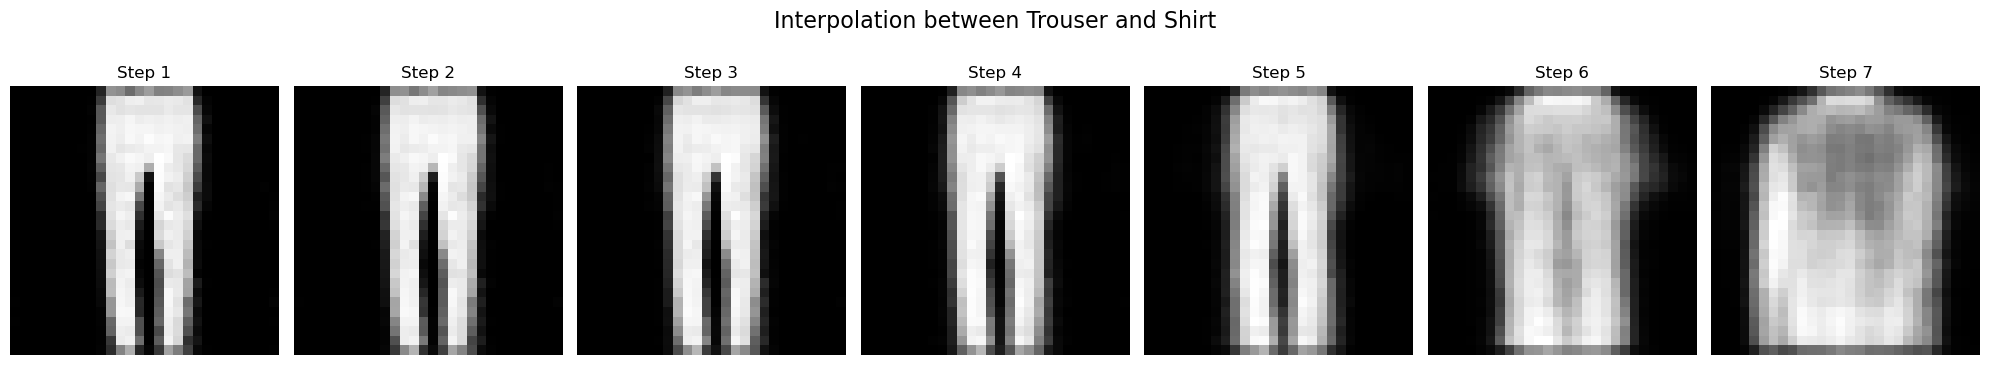

In [43]:
# interpolate between the two samples
# Define the number of interpolation steps
num_steps = 7

# Create interpolation steps between the two latent vectors
interpolation_steps = torch.linspace(0, 1, num_steps).unsqueeze(1).to(device)
interpolated_latents = sample_trouser_latent * (1 - interpolation_steps) + sample_shirt_latent * interpolation_steps

# Generate images from the interpolated latent vectors
vad.eval()
with torch.no_grad():
    interpolated_images = vad(interpolated_latents)

# Visualize the interpolated images
fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
for i in range(num_steps):
    axes[i].imshow(interpolated_images[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Step {i+1}')

plt.suptitle('Interpolation between Trouser and Shirt', fontsize=16)
plt.tight_layout()
plt.show()


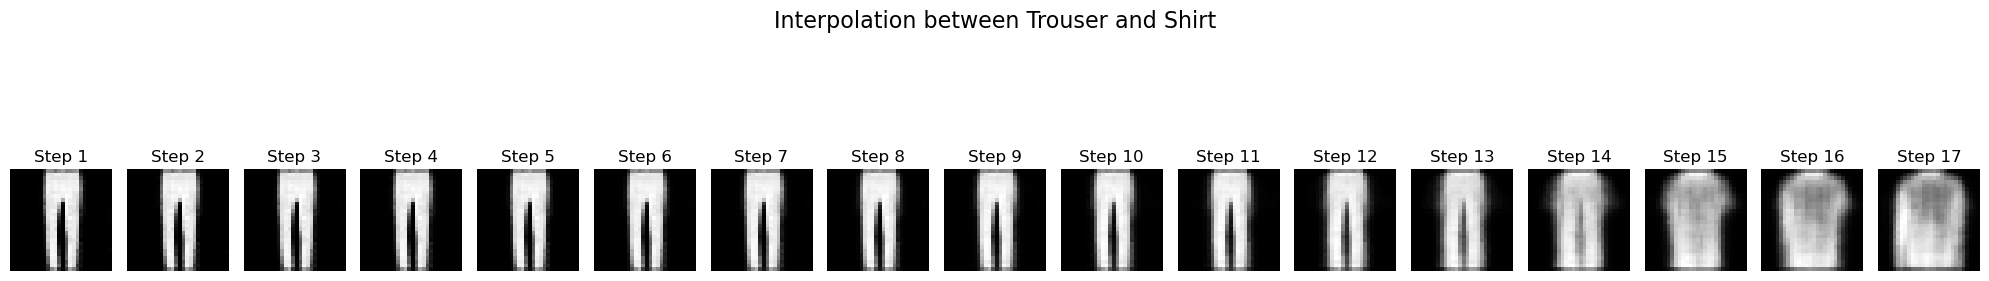

In [44]:
# interpolate between the two samples
# Define the number of interpolation steps
num_steps = 17

# Create interpolation steps between the two latent vectors
interpolation_steps = torch.linspace(0, 1, num_steps).unsqueeze(1).to(device)
interpolated_latents = sample_trouser_latent * (1 - interpolation_steps) + sample_shirt_latent * interpolation_steps

# Generate images from the interpolated latent vectors
vad.eval()
with torch.no_grad():
    interpolated_images = vad(interpolated_latents)

# Visualize the interpolated images
fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
for i in range(num_steps):
    axes[i].imshow(interpolated_images[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Step {i+1}')

plt.suptitle('Interpolation between Trouser and Shirt', fontsize=16)
plt.tight_layout()
plt.show()
